In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels as sm
import seaborn as sns
import os

In [102]:
df=pd.read_csv('kc_house_data.csv')

In [56]:
df.drop(['id','date','zipcode'],axis=1,inplace=True)

# Issues with matplotlib

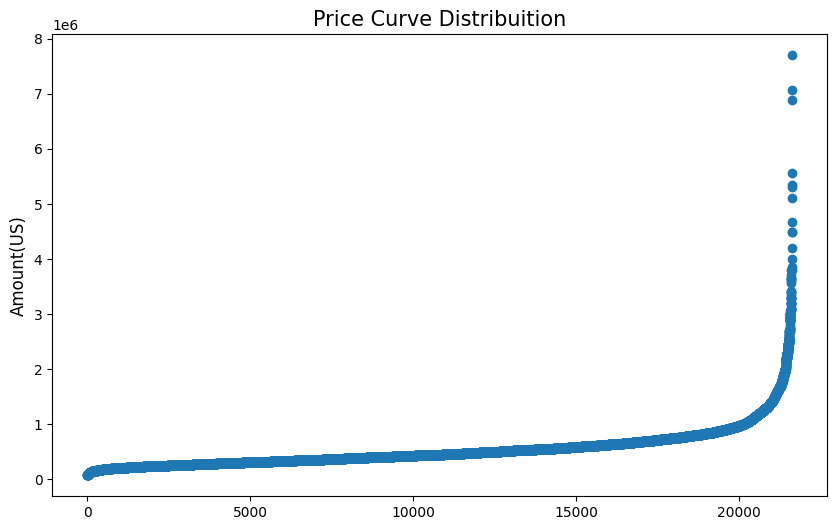

In [89]:
plt.figure(figsize = (10, 6))
plt.scatter(range(df.shape[0]),np.sort(df.price.values))
plt.title("Price Curve Distribuition", fontsize=15)
plt.xlabel("")
plt.ylabel("Amount(US)", fontsize=12)
plt.show()

In [91]:
print("Price Min")
print(df['price'].min())
print("Price Mean")
print(df['price'].mean())
print("Price Median")
print(df['price'].median())
print("Price Max")
print(df['price'].max())
print("Price Std")
print(df['price'].std())

Price Min
75000.0
Price Mean
540088.1417665294
Price Median
450000.0
Price Max
7700000.0
Price Std
367127.1964826997


In [92]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [101]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE

In [103]:
df.drop(['id', 'date'], axis=1, inplace=True)
X = df.drop("price",axis=1).values
y = df["price"].values

In [106]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

In [112]:
pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed, tol=1))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )

pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e2, degree=5))
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed))
                 ]))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))
#pipelines.append(
#                ("Scaled_ADA-Reg",
#                 Pipeline([
#                     ("Scaler", StandardScaler()),
#                     ("ADA-reg", AdaBoostRegressor())
#                 ]))) 

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())
                 ])))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())
                 ])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 7

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed,shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results[0])    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    


Scaled_Ridge: 0.695666 (+/- 0.012796)
Scaled_Lasso: 0.648083 (+/- 0.013825)
Scaled_Elastic: 0.666185 (+/- 0.015442)
Scaled_SVR: 0.627786 (+/- 0.016394)
Scaled_RF_reg: 0.871618 (+/- 0.019357)
Scaled_ET_reg: 0.873630 (+/- 0.016020)
Scaled_BR_reg: 0.859957 (+/- 0.024454)
Scaled_Hub-Reg: 0.658816 (+/- 0.015762)
Scaled_BayRidge: 0.695675 (+/- 0.012801)
Scaled_XGB_reg: 0.884273 (+/- 0.015347)
Scaled_DT_reg: 0.730800 (+/- 0.044833)
Scaled_KNN_reg: 0.779738 (+/- 0.019296)
Scaled_Gboost-Reg: 0.861569 (+/- 0.017826)
Scaled_RFR_PCA: 0.643407 (+/- 0.033800)
Scaled_XGBR_PCA: 0.626923 (+/- 0.041283)


In [113]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [114]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [115]:
y_hat = xgb.predict(X_test)

In [116]:
xgb.score(X_test,y_test)

0.8984549315305932